# PT Figure Notebook
## Sid Gurajala
## 05/01/2023

## Libraries 

In [1]:
library(patchwork)
library(purrr)
library(dplyr) 
library(tidyverse) 
library(cowplot)
library(singlecellmethods)
library(ggplot2)
library(ggbeeswarm)
library(stringr)

source("/data/srlab/anathan/scripts/scseq_utils.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


The following object is masked from ‘package:patchwork’:

    align_plots


Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    

In [2]:
labelfontsize = 20
tickfontsize = 16

figdir = '../../figures/components/'

In [3]:
# source("/data/srlab/ssg34/SLE_kidney_v2/scripts/libs/kidney_utils_updated.r")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: viridisLite

Loading required package: Rcpp



In [4]:
# source("/data/srlab/ssg34/SLE_kidney_v2/scripts/libs/kidney_utils.r")
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

In [ ]:
ind_meta <- all_meta %>% 
                    select(sample, broad.group) %>% 
                    table() %>% data.frame() %>% filter(broad.group != "UND")

In [ ]:
ind_keep <- vector() 

for (i in unique(ind_meta$sample)) {
    ind_subset <- ind_meta %>% filter(sample == i)
        if (all(ind_subset$Freq > 100)) {
            ind_keep <- c(ind_keep, i)
        }
}

In [ ]:
norm <- norm[, all_meta$cell]

In [ ]:
qq_pb_sc <- data.frame(nrow = nrow(norm))
individuals_sc <- vector()
cell_types_sc <- vector() 

for (i in ind_keep) {
    for (j in unique(ind_meta$broad.group)) {
            subset <- all_meta %>% filter(sample == i, 
                                                 broad.group == j,
                                                 dataset == "scRNAseq") %>% 
                        pull(cell)
            pb_vec <- rowMeans(norm[, subset])
            qq_pb_sc <- cbind(qq_pb_sc, pb_vec)
            individuals_sc <- c(individuals_sc, i)
            cell_types_sc <- c(cell_types_sc, j)
    }
}

qq_pb_sn <- data.frame(nrow = nrow(norm))
individuals_sn <- vector()
cell_types_sn <- vector() 

for (i in ind_keep) {
    for (j in unique(ind_meta$broad.group)) {
            subset <- all_meta %>% filter(sample == i, 
                                                 broad.group == j,
                                                 dataset == "snRNAseq") %>% 
                        pull(cell)
            pb_vec <- rowMeans(norm[, subset])
            qq_pb_sn <- cbind(qq_pb_sn, pb_vec)
            individuals_sn <- c(individuals_sn, i)
            cell_types_sn <- c(cell_types_sn, j)
    }
}

# PT

In [5]:
pt_harmony <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-04-06_harmony_500nGene_1000nUMI_3.rds')
pt_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-06-30_meta_500nGene_1000nUMI_3.rds')
pt_umap <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-04-06_UMAPobject_500nGene_1000nUMI_3.rds')

In [6]:
qcd_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-06-30_meta_500nGene_1000nUMI_3.rds')

In [7]:
qcd_meta <- qcd_meta %>% rename(new_cluster_number = hres.0.4)

In [16]:
sn_control <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_control)
sn_LN <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_LN)
sc_control <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_control)
sc_LN <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_LN)
merged <- sc_LN %>% left_join(sc_control) %>% left_join(sn_LN) %>% left_join(sn_control)
merged[is.na(merged)] <- "0 (0)"
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_summary_04152024.csv', quote = FALSE, row.names = FALSE)

Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"


In [18]:
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_summary_04152024.csv', quote = FALSE, row.names = FALSE)

## PT SUBTYPES

In [2]:
pt_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-06-30_meta_500nGene_1000nUMI_3.rds')

In [8]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [9]:
final_annotation <- data.frame(hres.0.4 = as.factor(seq(0, 7)),
                               final_annotation = c("PT0. Late Injuryhigh",
                                                    "PT1. SLC7A7high ALBhigh S1/S2",
                                                    "PT2. Low Quality",
                                                    "PT3. PCK1high DXCRhigh S2/S3",
                                                    "PT4. ANPEPhigh APOMhigh S1/S2",
                                                    "PT5. Late Injurylow S1/S2",
                                                    "PT6. PKHD1high SLC3A1high S2/S3",
                                                    "PT7. DTL"))

In [10]:
#pt_meta <- pt_meta %>% left_join(percent_mito)
pt_meta <- pt_meta %>% left_join(final_annotation)

Joining with `by = join_by(hres.0.4, final_annotation)`


In [11]:
saveRDS(pt_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
saveRDS(pt_meta %>% select(-c(Annot.separate, predicted_broad, predicted_fine)),
        '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
pt_norm <- norm[, pt_meta$cell]
saveRDS(pt_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')

### Cluster UMAPs

In [11]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [4]:
percent_mito <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/percent_mito_from_rawcounts_12072023.rds')
pt_meta <- left_join(pt_meta, percent_mito)
saveRDS(pt_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

Joining, by = "cell"


In [12]:
pt_meta <- pt_meta %>% left_join(final_annotation)
cluster_center <- pt_meta %>%
                  group_by(hres.0.4, final_annotation) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

Joining with `by = join_by(hres.0.4, final_annotation)`
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [13]:
qcd_norm = readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')

In [12]:
qcd_meta = pt_meta

In [9]:
pt_meta %>% colnames()

[1] "cell"             "sample"           "dataset"          "Site"            
 [5] "Type"             "processing.batch" "nCount_RNA"       "nFeature_RNA"    
 [9] "broad.type"       "doublet_score"    "uwotUMAP1"        "uwotUMAP2"       
[13] "hPC-1"            "hPC-2"            "hPC-3"            "hPC-4"           
[17] "hPC-5"            "hPC-6"            "hPC-7"            "hPC-8"           
[21] "hPC-9"            "hPC-10"           "hPC-11"           "hPC-12"          
[25] "hPC-13"           "hPC-14"           "hPC-15"           "hPC-16"          
[29] "hPC-17"           "hPC-18"           "hPC-19"           "hPC-20"          
[33] "id"               "cc"               "huwotUMAP1"       "huwotUMAP2"      
[37] "hres.0.1"         "hres.0.2"         "hres.0.3"         "hres.0.4"        
[41] "hres.0.6"         "hres.0.8"         "hres.1.2"         "hres.1.6"        
[45] "hres.2.0"         "final_annotation"

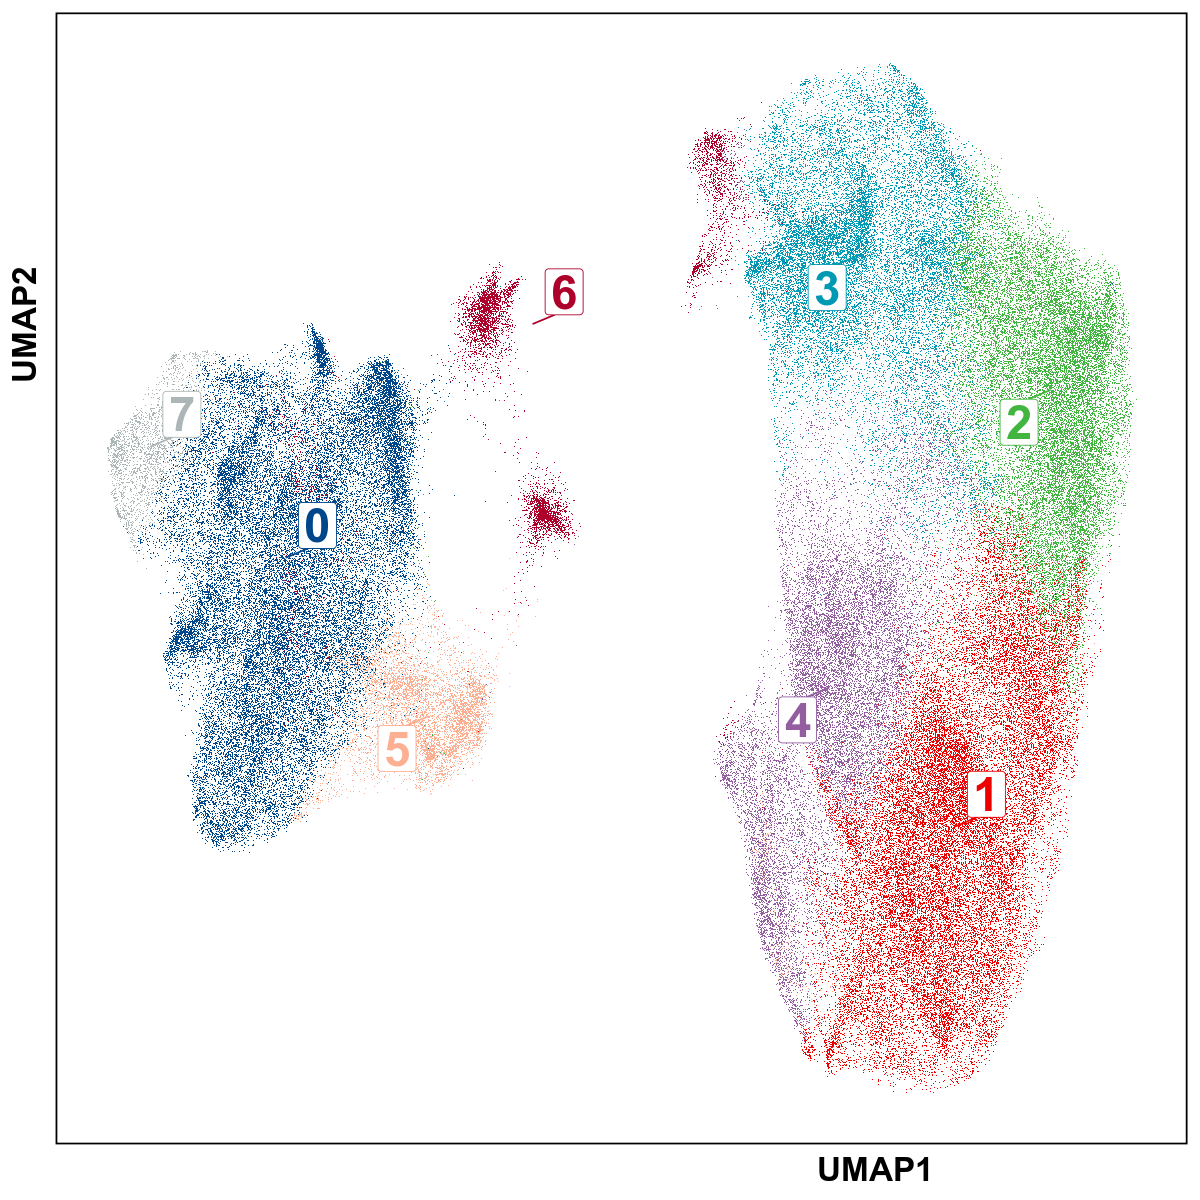

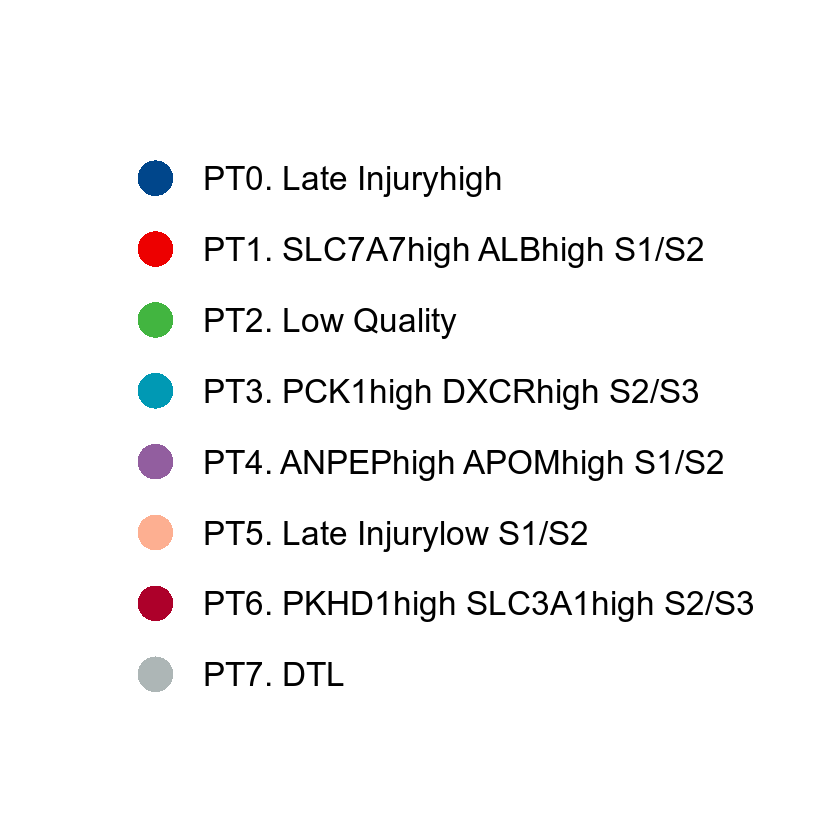

In [16]:
options(warn=-1)
cluster_center <- pt_meta %>%
                  group_by(hres.0.4, final_annotation) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

options(repr.plot.height = 9, repr.plot.width = 18)
p <- ggplot() +
      geom_point(
       data = pt_meta[sample(nrow(pt_meta)), ] %>% 
      select(huwotUMAP1, huwotUMAP2, final_annotation, hres.0.4) %>% 
              mutate(hres.0.4 = as.factor(hres.0.4)),
        aes(x = huwotUMAP1, y = huwotUMAP2, color = final_annotation),
          size = 0.25, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = huwotUMAP1, y = huwotUMAP2, 
            label = hres.0.4, color = as.factor(final_annotation)),
        size = 10,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    ggsci::scale_color_lancet()   +
    theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1),
              legend.text = element_text(size = 20),
              legend.title = element_blank()
          
    ) +
    theme(text=element_text(family="Arial")) + 
        labs(x = "UMAP1", y = "UMAP2") +
        guides(color = guide_legend(ncol = 1, override.aes = list(size = 15)))
legend <- cowplot::get_legend(p)
p <- p + theme(legend.position = "none")
legend <- cowplot::plot_grid(legend)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2d.png",
       p,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2d-legend.png",
       legend,
       base_height = 7,
       base_width = 7)
fig.size(10, 10)
p
fig.size(7, 7)
legend
options(warn=0)

### Single Cell UMAP, Single Nuclear UMAP

In [13]:
qcd_meta = qcd_meta %>% rename(hUMAP1 = huwotUMAP1, hUMAP2 = huwotUMAP2)

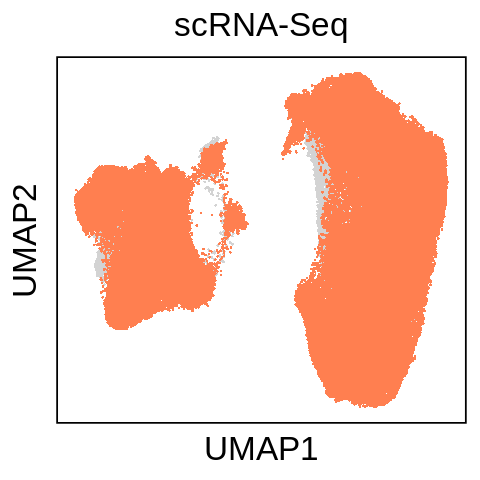

In [17]:
umap_plot = ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(dataset == "scRNAseq") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "coral"
  ) +
theme_classic(base_size = tickfontsize) +
  theme(
    legend.position = "none",
         plot.title = element_text(size = labelfontsize, hjust = 0.5),
          axis.title = element_text(size = labelfontsize), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          text=element_text(family="Arial")
  ) + labs(x = "UMAP1", y = "UMAP2", title = 'scRNA-Seq') 


outplot = umap_plot

height = 4
width = 4
fig.size(height, width)
outplot

ggsave(paste0(figdir, 'pt_umap_sc.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_umap_sc.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


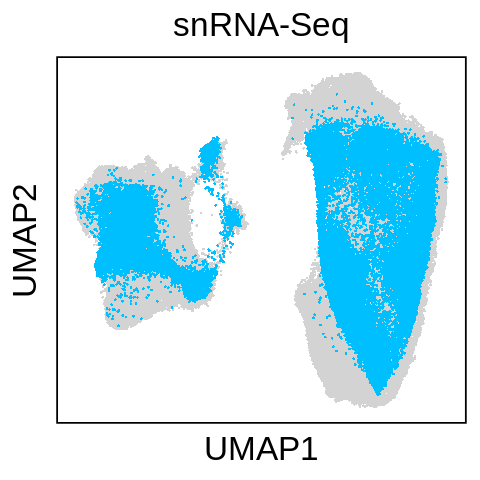

In [16]:
umap_plot = ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(dataset == "snRNAseq") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "deepskyblue"
  ) +
theme_classic(base_size = tickfontsize) +
  theme(
    legend.position = "none",
         plot.title = element_text(size = labelfontsize, hjust = 0.5),
          axis.title = element_text(size = labelfontsize), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          text=element_text(family="Arial")
  ) + labs(x = "UMAP1", y = "UMAP2", title = 'snRNA-Seq') 


outplot = umap_plot

height = 4
width = 4
fig.size(height, width)
outplot

ggsave(paste0(figdir, 'pt_umap_sn.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_umap_sn.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

### Marker Gene UMAPs

In [20]:
markers = c('CUBN', 'SLC34A1', 'SLC22A8', 'MOGAT1')

In [21]:
qcd_scaled = qcd_norm[markers, ] %>% scaleData
vmax = qcd_scaled %>% quantile(.95)
vmin = qcd_scaled %>% quantile(.05)

In [22]:
p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[1], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p1 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[2], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p2 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[3], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p3 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[4], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p4 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

umap_legend = get_legend(p +theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
                theme(text=element_text(family="Arial"))))
umap_legend = cowplot::plot_grid(umap_legend) 

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


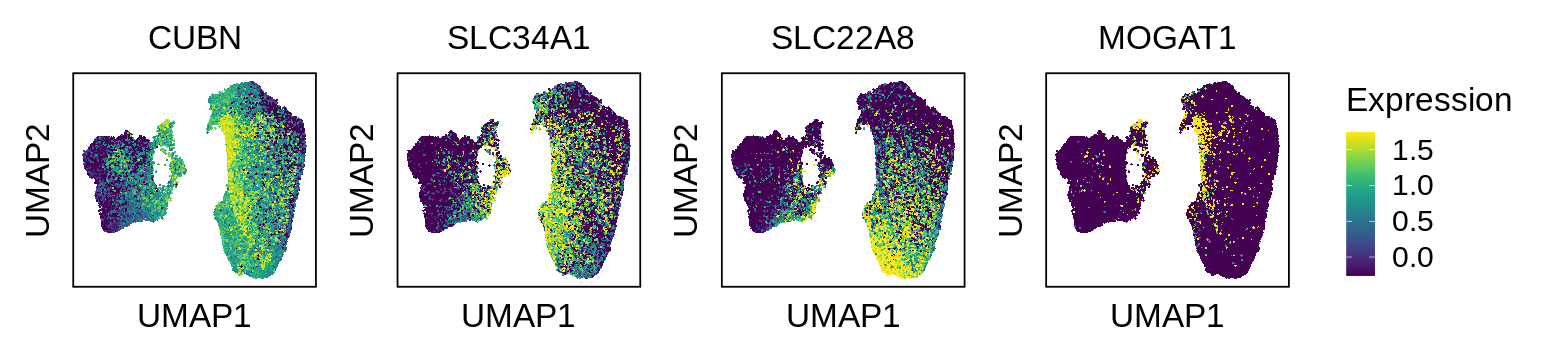

In [25]:
height = 3
width = 13
fig.size(height, width)

outplot = p1 + p2 + p3 + p4 + umap_legend + plot_layout(nrow = 1)
outplot

ggsave(paste0(figdir, 'pt_umap_markers.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_umap_markers.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

### Gene Heatmaps

In [14]:
pt_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [15]:
final_annotation <- data.frame(hres.0.4 = as.factor(seq(0, 7)),
                               final_annotation = c("PT0. Late Injuryhigh",
                                                    "PT1. SLC7A7high ALBhigh S1/S2",
                                                    "PT2. Low Quality",
                                                    "PT3. PCK1high DXCRhigh S2/S3",
                                                    "PT4. ANPEPhigh APOMhigh S1/S2",
                                                    "PT5. Late Injurylow S1/S2",
                                                    "PT6. PKHD1high SLC3A1high S2/S3",
                                                    "PT7. DTL"))

pt_meta <- pt_meta %>% left_join(final_annotation)

Joining with `by = join_by(hres.0.4, final_annotation)`


In [16]:
qcd_meta = pt_meta

In [33]:
marker.genes <-  c("VCAM1", "TPM1", "DCDC2",
                    "PRODH2", "SLC22A8", "SLC7A7",  "ALB", "SLC5A2", "PCK1", "DCXR",
                    "ANPEP", "APOM", "SLC34A1", "SLC22A7",
                     "MOGAT1", "ABCC3", "SATB2",  
                     "PKHD1", "SLC3A1",   "LRP2",
                     "JAG1", "TACSTD2",
                  "FOS", "JUN", "EGR1"
                  )



In [ ]:
annotation.order = c("PT0. Late Injuryhigh",
                                                    "PT1. SLC7A7high ALBhigh S1/S2",
                                                    "PT2. Low Quality",
                                                    "PT3. PCK1high DXCRhigh S2/S3",
                                                    "PT4. ANPEPhigh APOMhigh S1/S2",
                                                    "PT5. Late Injurylow S1/S2",
                                                    "PT6. PKHD1high SLC3A1high S2/S3",
                                                    "PT7. DTL")

In [18]:
library(googlesheets4)
gs4_deauth()

tissue_names = read_sheet("https://docs.google.com/spreadsheets/d/1f94hwyuDMvSUQyelWM89xfhDos7izNQw9bQ4amml2OQ/edit?usp=sharing", 
                 sheet = "Tissue")
tissue_names = setNames(tissue_names$Annotation_latest, tissue_names$Annotation_v1)
qcd_meta = qcd_meta %>% mutate(final_annotation = recode(final_annotation, !!!tissue_names))

annotation.order = recode(annotation.order, !!!tissue_names)

✔ Reading from UpdatedClusterNames.

✔ Range ''Tissue''.



In [34]:
marker_genes = marker.genes

In [20]:
wilcox_sn <- wilcoxauc(qcd_norm[, qcd_meta %>% filter(dataset == 'snRNAseq') %>% pull(cell)], 
                       qcd_meta %>% filter(dataset == 'snRNAseq') %>% pull(final_annotation))
wilcox_sc <- wilcoxauc(qcd_norm[, qcd_meta %>% filter(dataset == 'scRNAseq') %>% pull(cell)], 
                       qcd_meta %>% filter(dataset == 'scRNAseq') %>% pull(final_annotation))

In [35]:
sc_plot_df <- wilcox_sc %>%  filter(feature %in% marker_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
sn_plot_df <- wilcox_sn %>%  filter(feature %in% marker_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [22]:
setdiff(sc_plot_df$group, annotation.order)

character(0)

In [36]:
title = 'scRNA-seq'
dat_all = sc_plot_df %>% rename(percent = pct_in, zscore = avgExpr_scaled) 

dat = dat_all %>% pivot_wider(id_cols = 'feature', names_from = 'group', 
                    values_from = 'zscore') %>% as.data.frame
rownames(dat) = dat$feature
dat = dat %>% select(-feature)
row.order = marker_genes
col.order = annotation.order
# row.order = rownames(dat)[hclust(dist(dat))$order]
# col.order = colnames(dat)[hclust(dist(t(dat)))$order]
dat = dat_all
dat$group = factor(dat$group, levels = col.order)
dat$feature = factor(dat$feature, levels = row.order)

# dat = dat[!is.na(dat$group), ]

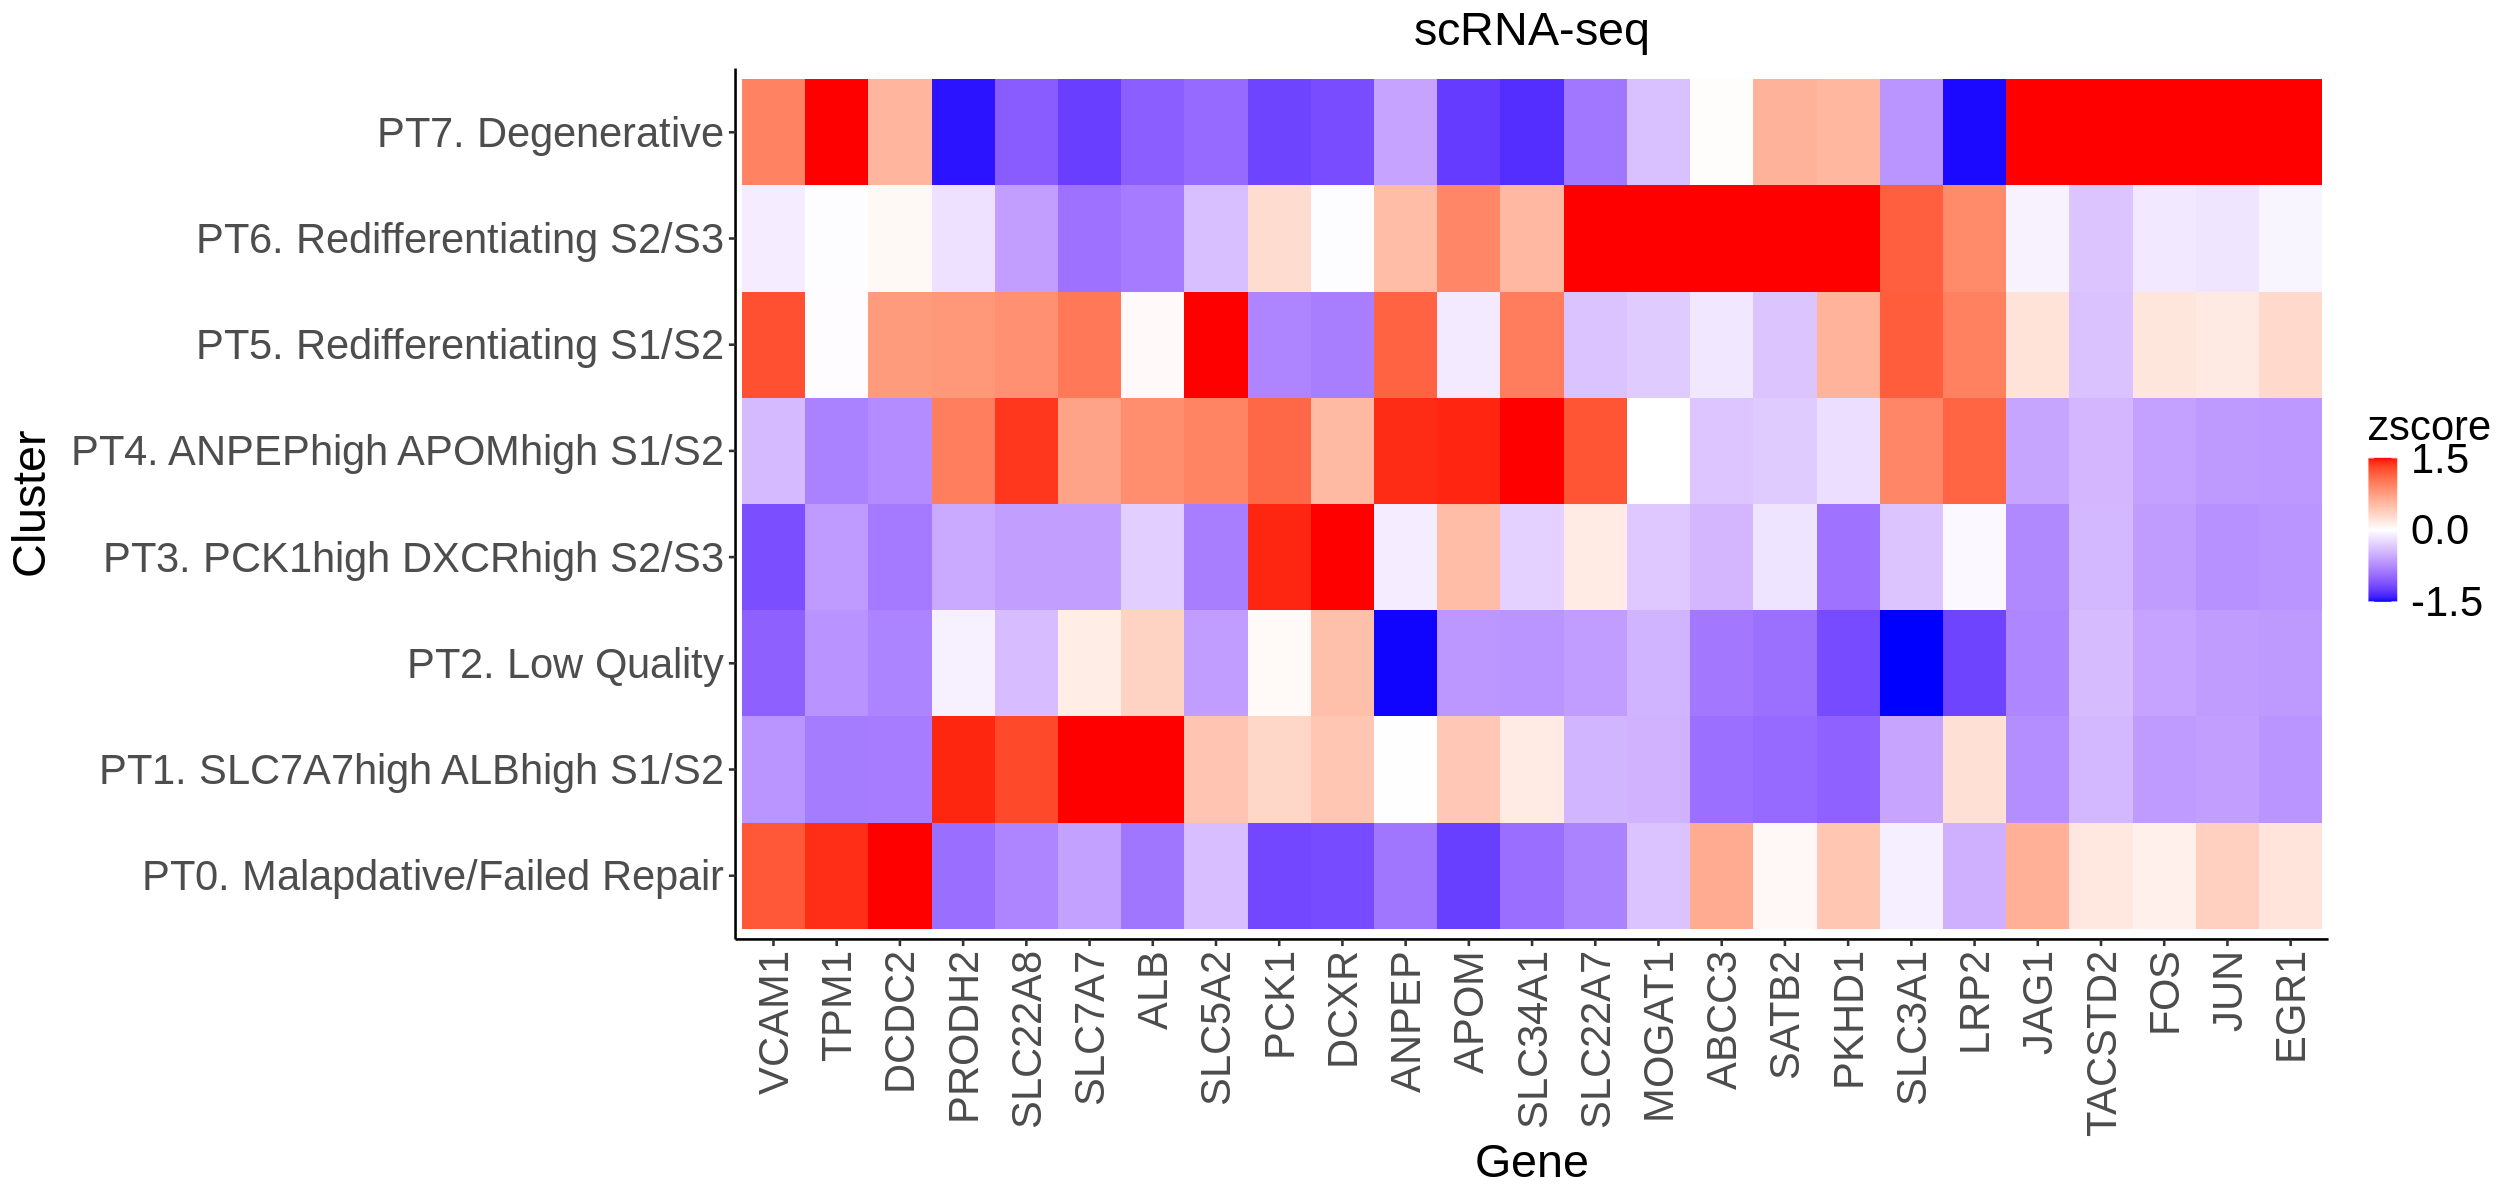

In [38]:
height = 10
width = 21
fig.size(height, width)


marker_heatmap = ggplot(dat, 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = tickfontsize) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-1.5, 1.5), 
                         oob = scales::squish, breaks = c(-1.5, 0, 1.5)) + 
    # scale_x_discrete(limits = marker_genes) + 
    # scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
          axis.text = element_text( size = labelfontsize+5),
          axis.title = element_text(size = labelfontsize+8), 
          plot.title = element_text(size = labelfontsize+8, hjust = 0.5), 
          legend.text = element_text(size = labelfontsize+5),
          legend.title = element_text(size = labelfontsize+5)

         ) + 
    labs(x = "Gene", y = "Cluster", title = title)

outplot = marker_heatmap
outplot

ggsave(paste0(figdir, 'pt_sc_heatmap_markers.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_sc_heatmap_markers.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

In [39]:
title = 'snRNA-seq'
dat_all = sn_plot_df %>% rename(percent = pct_in, zscore = avgExpr_scaled) 

# dat = dat_all %>% pivot_wider(id_cols = 'feature', names_from = 'group', 
#                     values_from = 'zscore') %>% as.data.frame
# rownames(dat) = dat$feature
# dat = dat %>% select(-feature)
# row.order = rownames(dat)[hclust(dist(dat))$order]
# col.order = colnames(dat)[hclust(dist(t(dat)))$order]
dat = dat_all
dat$group = factor(dat$group, levels = col.order)
dat$feature = factor(dat$feature, levels = row.order)
# dat = dat[!is.na(dat$group), ]

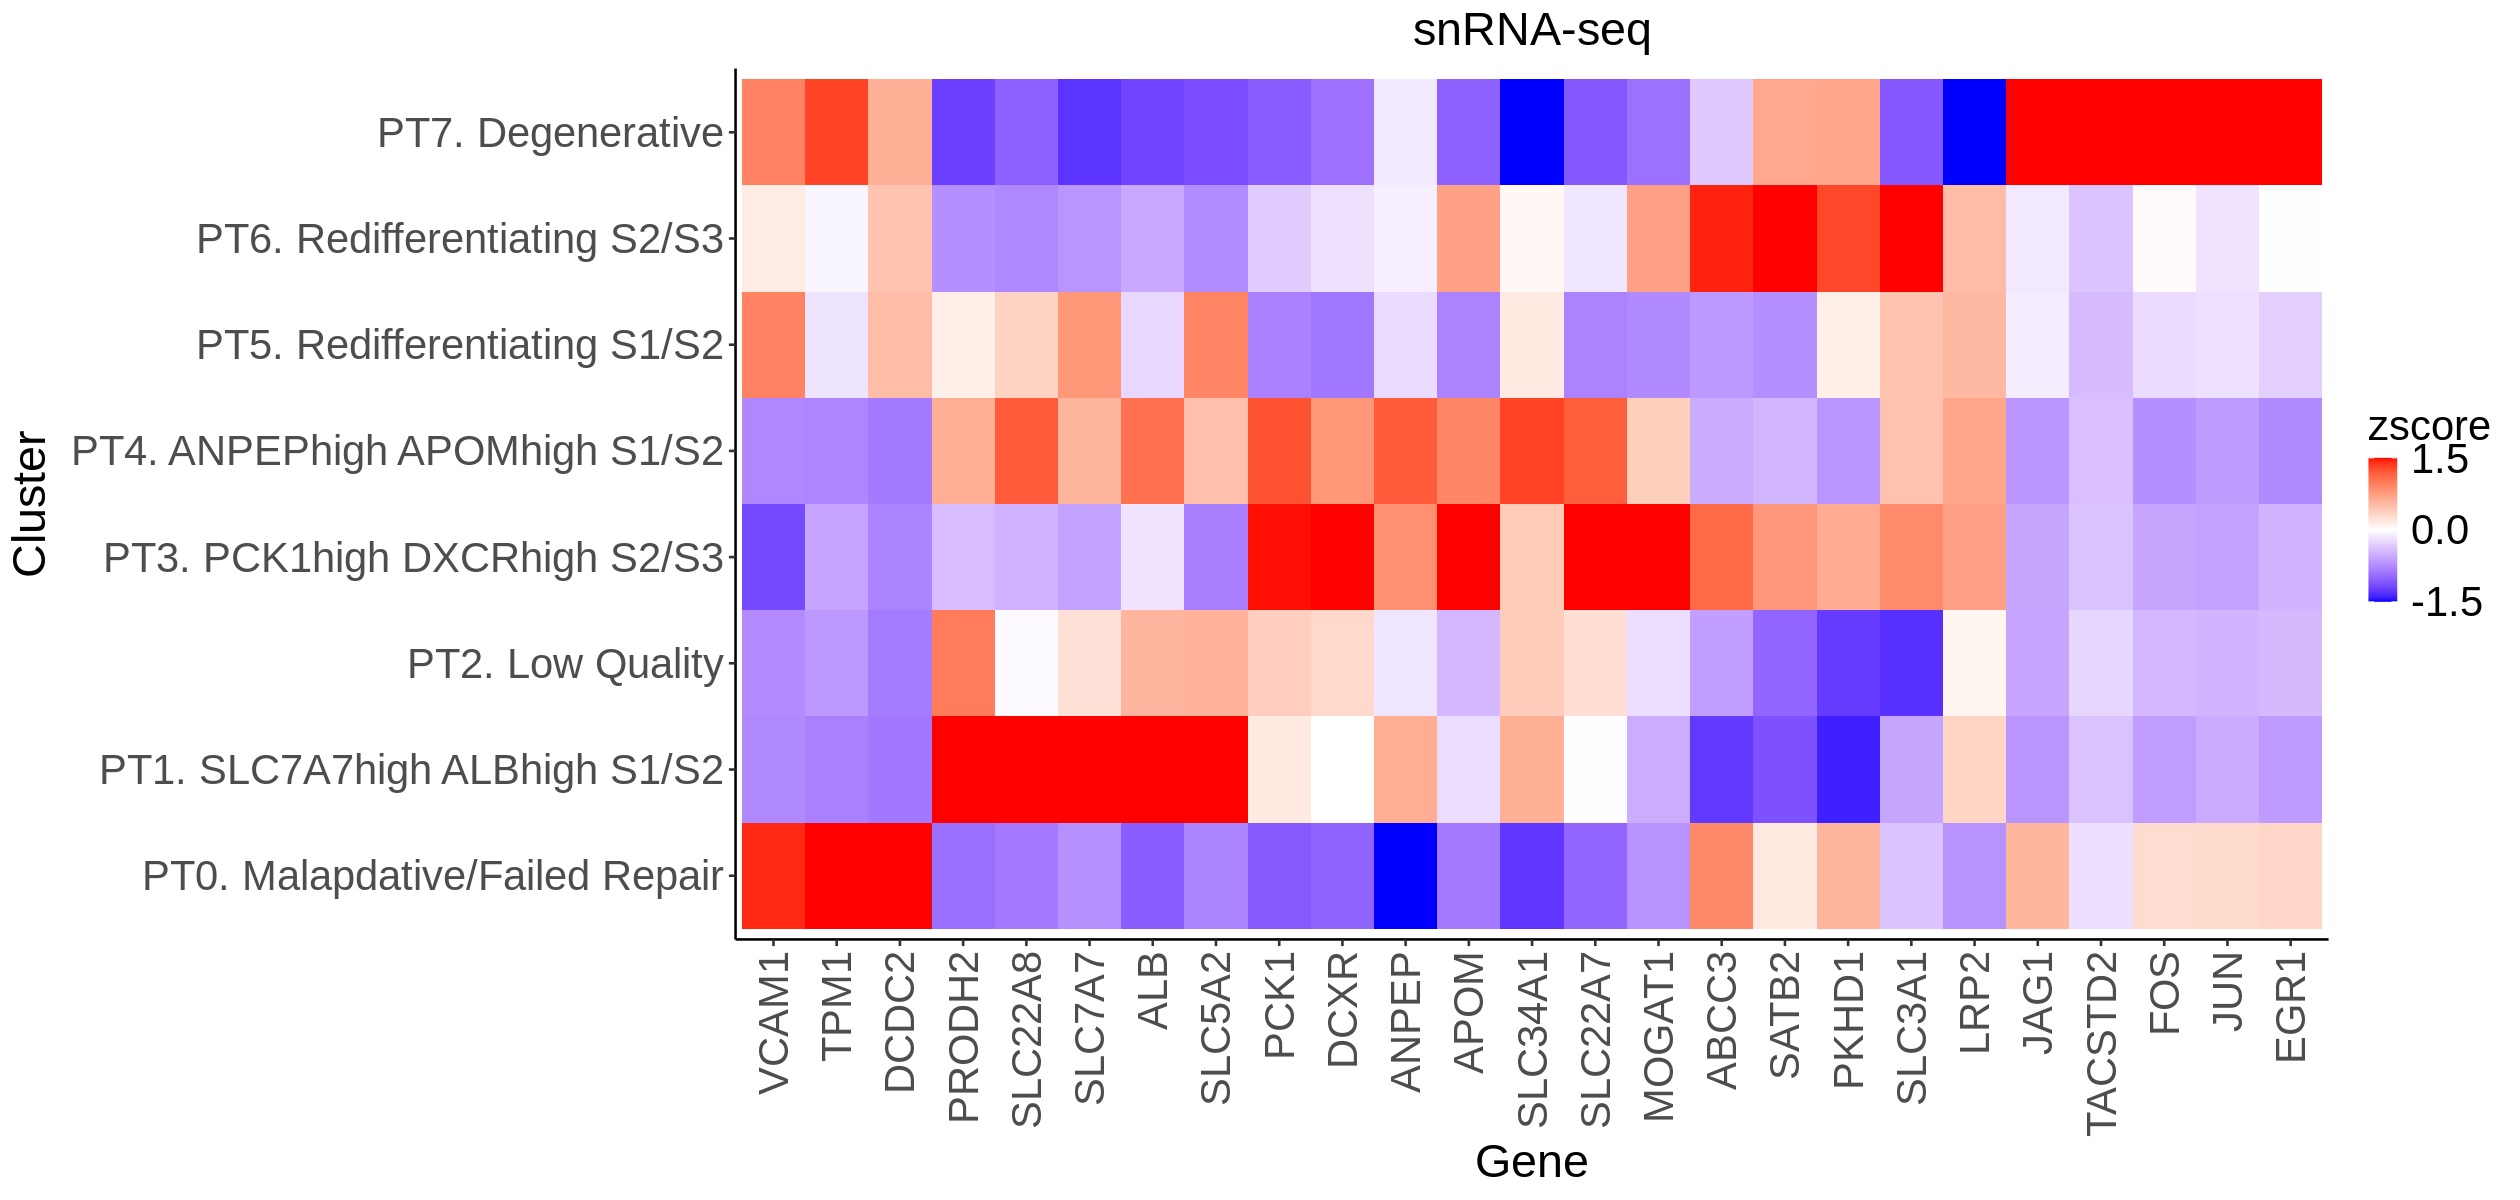

In [40]:
height = 10
width = 21
fig.size(height, width)


marker_heatmap = ggplot(dat, 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = tickfontsize) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-1.5, 1.5), 
                         oob = scales::squish, breaks = c(-1.5, 0, 1.5)) + 
    # scale_x_discrete(limits = marker_genes) + 
    # scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
          axis.text = element_text( size = labelfontsize+5),
          axis.title = element_text(size = labelfontsize+8), 
          plot.title = element_text(size = labelfontsize+8, hjust = 0.5), 
          legend.text = element_text(size = labelfontsize+5),
          legend.title = element_text(size = labelfontsize+5)

         ) + 
    labs(x = "Gene", y = "Cluster", title = title)

outplot = marker_heatmap
outplot

ggsave(paste0(figdir, 'pt_sn_heatmap_markers.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_sn_heatmap_markers.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

In [40]:
injury_genes_kpmp <- c(
"ITGB8", 
"CDH6", 
"DCDC2", 
"TPM1", 
"VCAM1", 
"DLGAP1", 
"ACSM3", 
"KIF26B", 
"HAVCR1")
injury_genes_aki_pnas <- c(
  "VCAM1",
  "CCL2",
  "ITGAV",
  "CD44",
  "CXCL2",
  "ZBTB7C",
  "CFTR",
  "CXCL1",
  "MALT1",
  "NFKB1"
)
injury_genes_injury_pred_nature <- c(
  "DCC",
  "DLGAP1",
  "RHEX",
  "ITGB8",
  "CDH6",
  "SEMA5A",
  "AC016383.2",
  "ROBO2",
  "CREB5",
  "CLSTN2"
)

In [42]:
length(injury_genes_injury_pred_nature)

[1] 10

In [44]:
plot_df <- wilcox %>%  filter(feature %in% injury_genes_kpmp) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
fig.size(6, 12)
heatmap <- ggplot(plot_df %>% rename(percent = pct_in), 
               aes(y = group, x = feature, 
                   fill = avgExpr_scaled)) + 
    geom_tile(width = 0.75, height = 0.75) + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-1.5, 1.5), 
                         oob = scales::squish,
                         name = "Z-score") +
    scale_x_discrete(limits = injury_genes_kpmp)  + 
    scale_y_discrete(limits = annotation.order) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(size = 18),
          axis.title = element_text(size = 15),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 12)) + 
    theme(text=element_text(family="Arial")) + 
    labs(x = "", y = "")
heatmap
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure1/pt_injury_kpmp.png",
       heatmap,
       base_height = 6,
       base_width = 12)

ERROR: Error in value[[3L]](cond): could not open file '/tmp/1631.tmpdir/Rtmp1nEZzr/file56b2232838b.png'


plot without title

In [37]:
plot_df <- wilcox %>%  filter(feature %in% injury_genes_aki_pnas) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
fig.size(6, 12)
heatmap <- ggplot(plot_df %>% rename(percent = pct_in), 
               aes(y = group, x = feature, 
                   fill = avgExpr_scaled)) + 
    geom_tile(width = 0.75, height = 0.75) + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-1.5, 1.5), 
                         oob = scales::squish,
                         name = "Z-score") +
    scale_x_discrete(limits = injury_genes_aki_pnas)  + 
    scale_y_discrete(limits = annotation.order) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(size = 18),
          axis.title = element_text(size = 15),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 12)) + 
    theme(text=element_text(family="Arial")) + 
    labs(x = "", y = "")
heatmap
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure1/pt_injury_aki_pnas.png",
       heatmap,
       base_height = 6,
       base_width = 20)

ERROR: Error in value[[3L]](cond): could not open file '/tmp/1631.tmpdir/Rtmp1nEZzr/file56b23b7e7c2.png'


plot without title

In [43]:
plot_df <- wilcox %>%  filter(feature %in% injury_genes_injury_pred_nature) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
fig.size(6, 12)
heatmap <- ggplot(plot_df %>% rename(percent = pct_in), 
               aes(y = group, x = feature, 
                   fill = avgExpr_scaled)) + 
    geom_tile(width = 0.75, height = 0.75) + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-1.5, 1.5), 
                         oob = scales::squish,
                         name = "Z-score") +
    scale_x_discrete(limits = injury_genes_injury_pred_nature)  + 
    scale_y_discrete(limits = annotation.order) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(size = 18),
          axis.title = element_text(size = 15),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 12)) + 
    theme(text=element_text(family="Arial")) + 
    labs(x = "", y = "")
heatmap
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/extended_data/figure1/pt_injury_pred_nature.png",
       heatmap,
       base_height = 6,
       base_width = 12)

ERROR: Error in value[[3L]](cond): could not open file '/tmp/1631.tmpdir/Rtmp1nEZzr/file56b2d7a29bd.png'


plot without title

In [33]:
wilcox %>% 
    filter(group == "PT0. Late Injuryhigh") %>% 
    filter(feature %in% injury_genes_injury_pred_nature)

feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CLIC4,PT0. Late Injuryhigh,1.1324109,-0.16105418,3786412925,0.4420713,0.000000e+00,0.000000e+00,73.013911,71.321263
RHEX,PT0. Late Injuryhigh,0.6736973,0.46815852,5371709780,0.6271579,0.000000e+00,0.000000e+00,40.415483,16.138157
SULT1C4,PT0. Late Injuryhigh,0.6329033,0.50204252,6015767586,0.7023530,0.000000e+00,0.000000e+00,52.236080,14.245395
FMNL2,PT0. Late Injuryhigh,0.5298994,0.18732865,4895474565,0.5715565,0.000000e+00,0.000000e+00,40.773403,26.009505
SATB2,PT0. Late Injuryhigh,0.2906816,0.10021104,4676864688,0.5460334,0.000000e+00,0.000000e+00,26.425224,17.101308
ROBO2,PT0. Late Injuryhigh,0.1271584,0.11411671,4510329199,0.5265900,0.000000e+00,0.000000e+00,6.555109,1.277662
CLSTN2,PT0. Late Injuryhigh,0.4544203,0.30666290,5127203697,0.5986114,0.000000e+00,0.000000e+00,31.519132,12.327319
TNIK,PT0. Late Injuryhigh,0.5750208,0.24562385,5057021814,0.5904175,0.000000e+00,0.000000e+00,44.339692,26.411978
SLC2A9,PT0. Late Injuryhigh,0.4714016,-0.06502167,4294467928,0.5013878,2.483461e-01,3.211460e-01,35.114940,32.345924


### Cluster Proportions in Matched Patients

In [108]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [62]:
pt_meta <- pt_meta  %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3]) 

In [63]:
sample_freq <- pt_meta %>% select(dataset, individual, hres.0.4) %>% 
                    table() %>% data.frame() %>% 
                    pivot_wider(names_from = "hres.0.4", values_from = Freq) 

In [64]:
ind_list <- pt_meta %>% select(dataset, individual) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(names_from = 'dataset', values_from = "Freq") %>% filter(scRNAseq > 200 & snRNAseq > 200) %>% 
                pull(individual)

In [65]:
sample_freq_sc <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "scRNAseq") %>% 
                    select(-dataset) %>% colSums()

sample_freq_sn <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "snRNAseq") %>% 
                    select(-dataset) %>% colSums()

In [66]:
sample_freq <- data.frame(rep("a", 8))
sample_freq$sc_freq <- sample_freq_sc / sum(sample_freq_sc)
sample_freq$sc_se <- sqrt((sample_freq$sc_freq * (1 - sample_freq$sc_freq)) / sample_freq_sc)
sample_freq$sn_freq <- sample_freq_sn / sum(sample_freq_sn)
sample_freq$sn_se <- sqrt((sample_freq$sn_freq * (1 - sample_freq$sn_freq)) / sample_freq_sn)
sample_freq$hres.0.4 <- as.character(seq(0, 7))
sample_freq <- sample_freq[,- 1]

In [69]:
r = cor(sample_freq$sc_freq, sample_freq$sn_freq)
pval = cor.test(sample_freq$sc_freq, sample_freq$sn_freq)$p.value

In [70]:
format(pval, format = 'e', digits = 3)

[1] "0.00281"

In [74]:
title = 'Proximal Tubule'

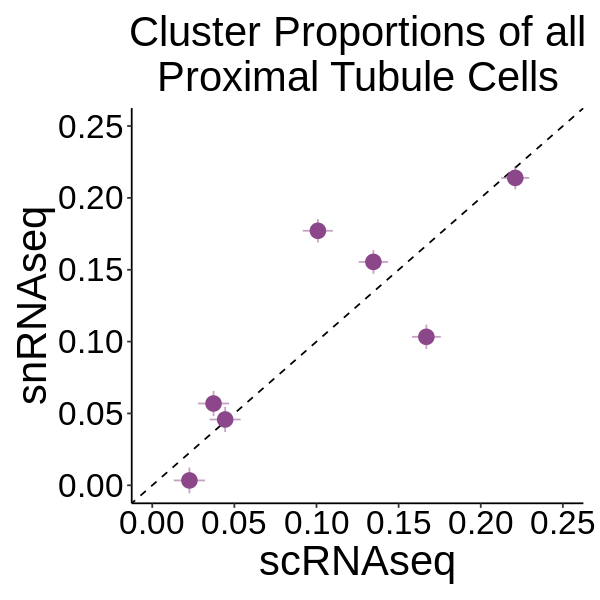

In [76]:
max_val <- max(sample_freq[, c("sc_freq", "sn_freq")])

p = ggplot(sample_freq, aes(x = sc_freq, y = sn_freq)) + 
    geom_abline(linetype = "dashed") +
    # scale_color_manual(values =as.vector(rev(palette36.colors(26)))) +
    theme_classic() + 
    geom_linerange(aes(ymax = sn_freq+1.96*sn_se, 
                        ymin = sn_freq-1.96*sn_se), alpha = 0.5, color = 'orchid4') +
    geom_linerange(aes(xmax = sc_freq+1.96*sc_se, 
                        xmin = sc_freq-1.96*sc_se), alpha = 0.5, color = 'orchid4') +
    geom_point(size = 4, color = 'orchid4') + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    coord_cartesian(xlim = c(0, 0.25), ylim = c(0, 0.25)) + 
    labs(x = "scRNAseq",
         y = "snRNAseq", title = paste0('Cluster Proportions of all\n', title, ' Cells'))+
    annotate("text", x = 0, y = 0.4, label = paste0('R=', round(r, 2)), hjust =0, 
         size =7)+
    annotate("text", x = 0, y = 0.36, label = paste0('P=', 
             format(pval, format = 'e', digits = 3)), hjust =0, 
         size =7)

p = p +theme(axis.text = element_text(color = "black", size = labelfontsize, vjust = 0.5),
           axis.title = element_text(size=labelfontsize+5, hjust = 0.5),
            legend.text = element_text(size = labelfontsize),
            legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize+5),
                theme(text=element_text(family="Arial")),
                                    plot.margin = margin(10, 10, 10, 10))
height = 5
width = 5
fig.size(height, width)

outplot = p
outplot

ggsave(paste0(figdir, 'pt_scsn_cellfreqcorr.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pt_scsn_cellfreqcorr.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

In [73]:
cor.test(sample_freq$sc_freq, sample_freq$sn_freq)


	Pearson's product-moment correlation

data:  sample_freq$sc_freq and sample_freq$sn_freq
t = 4.8646, df = 6, p-value = 0.00281
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5085812 0.9806352
sample estimates:
      cor 
0.8931603 


In [67]:
lateinjury_high_prop <- pt_meta %>% 
                filter(dataset == 'scRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT0. Late Injuryhigh")
saveRDS(lateinjury_high_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlecell_05102024.rds')
lateinjury_low_prop <- pt_meta %>% 
                filter(dataset == 'scRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT5. Late Injurylow S1/S2")
saveRDS(lateinjury_low_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_lowprop_singlecell_05102024.rds')

In [333]:
lateinjury_high_prop <- pt_meta %>% 
                filter(dataset == 'snRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT0. Late Injuryhigh")
saveRDS(lateinjury_high_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlenuc_05102024.rds')
lateinjury_low_prop <- pt_meta %>% 
                filter(dataset == 'snRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT5. Late Injurylow S1/S2")
saveRDS(lateinjury_low_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_lowprop_singlenuc_05102024.rds')


	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 6.1665, df = 48, p-value = 1.395e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4742731 0.7959087
sample estimates:
      cor 
0.6648519 



	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 3.3023, df = 48, p-value = 0.001816
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1725879 0.6328243
sample estimates:
      cor 
0.4302659 



	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 3.3023, df = 48, p-value = 0.001816
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1725879 0.6328243
sample estimates:
      cor 
0.4302659 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


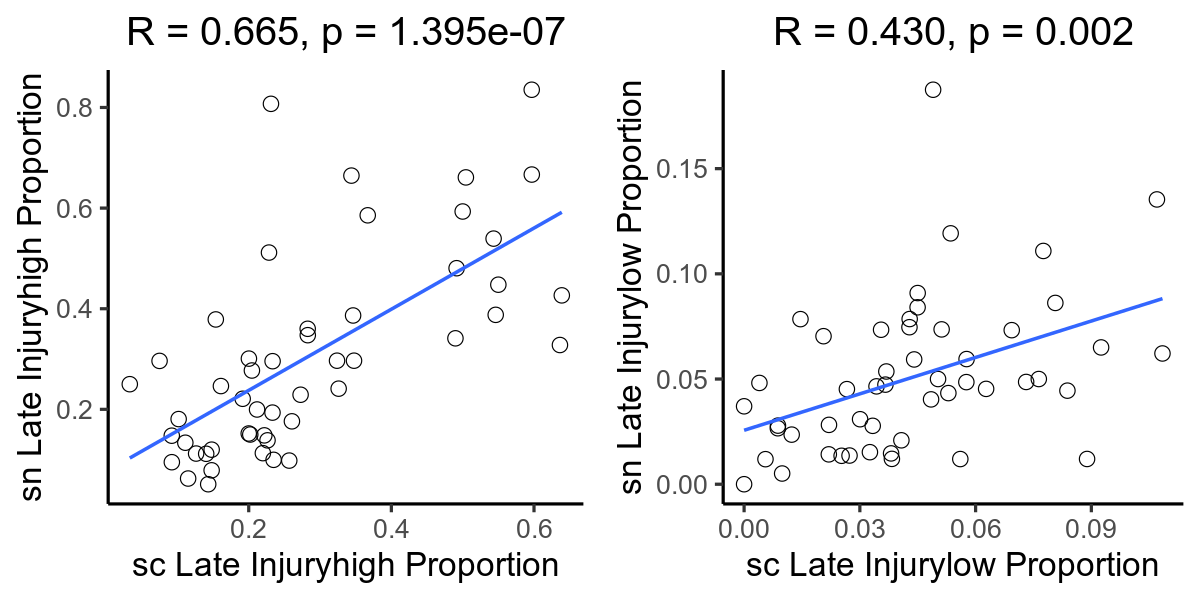

In [136]:
sn_list <- pt_meta %>% 
                filter(dataset == 'snRNAseq') %>% 
                pull(individual) %>% unique()
plot_df <- pt_meta %>% 
                select(individual, dataset, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual, dataset) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == 'PT0. Late Injuryhigh') %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, dataset, Prop) %>% 
                pivot_wider(names_from = 'dataset',
                            values_from = 'Prop')  %>% 
                filter(individual %in% sn_list)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

p1 <- ggplot(plot_df, 
           aes(x = scRNAseq, y = snRNAseq)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injuryhigh Proportion', 
         y = 'sn Late Injuryhigh Proportion',
         title = 'R = 0.665, p = 1.395e-07') + 
    theme(plot.title = element_text(hjust = 0.5))


plot_df <- pt_meta %>% 
                select(individual, dataset, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual, dataset) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT5. Late Injurylow S1/S2") %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, dataset, Prop) %>% 
                pivot_wider(names_from = 'dataset',
                            values_from = 'Prop')  %>% 
                filter(individual %in% sn_list)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

p2 <- ggplot(plot_df, 
           aes(x = scRNAseq, y = snRNAseq)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injurylow Proportion', 
         y = 'sn Late Injurylow Proportion',
         title = 'R = 0.430, p = 0.002') + 
    theme(plot.title = element_text(hjust = 0.5))
cowplot::plot_grid(p1, p2)


	Pearson's product-moment correlation

data:  plot_df$LateInjuryHigh and plot_df$LateInjuryLow
t = 5.2198, df = 183, p-value = 4.83e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2275377 0.4793620
sample estimates:
      cor 
0.3599891 


`geom_smooth()` using formula = 'y ~ x'


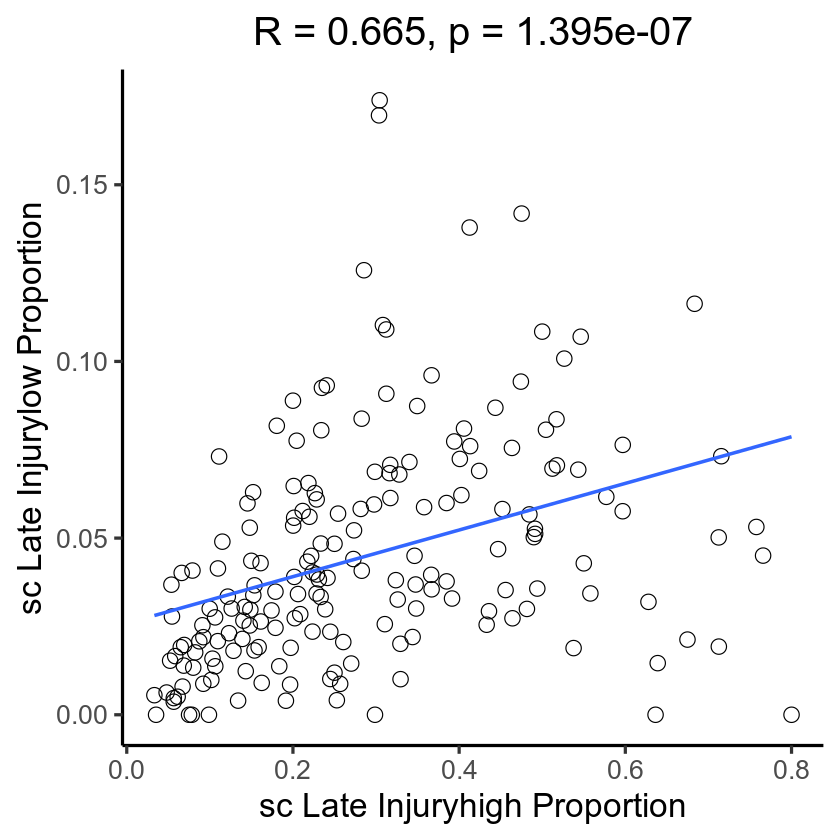

In [44]:
plot_df <- pt_meta %>% filter(dataset == 'scRNAseq') %>% 
                select(individual, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation %in% c('PT0. Late Injuryhigh',
                                               "PT5. Late Injurylow S1/S2")) %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, final_annotation, Prop) %>% 
                pivot_wider(names_from = 'final_annotation',
                            values_from = 'Prop')
colnames(plot_df) <- c("individual", "LateInjuryHigh", "LateInjuryLow")

cor.test(plot_df$LateInjuryHigh, plot_df$LateInjuryLow)

ggplot(plot_df, 
           aes(x = LateInjuryHigh, y = LateInjuryLow)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injuryhigh Proportion', 
         y = 'sc Late Injurylow Proportion',
         title = 'R = 0.360, p = 4.83e-07') + 
    theme(plot.title = element_text(hjust = 0.5))